# Задание:

## Выберите одну из трех фичей для анализа
- Понижение коэффициента surge, чтобы увеличить price-to-order конверсию (во время surge)<br>
Ожидаем: выше price-to-order конверсия во время surge
- Если юзер Android нажимает “отменить”, предлагать промокод в случае НЕ отмены<br>
Ожидаем: ниже отмены на Android устройствах
- При уточнении, уверен ли юзер в отмене заказа не из центра, добавить эмодзи котика, просящего не отменять<br>
Ожидаем: ниже отмены по заказам НЕ из центра

Отфильтруйте датасет по своей гипотезе. Используйте метрику, которая описана в блоке “Ожидаем”

In [1]:
import pandas as pd
df = pd.read_csv('post_abtest_data.csv')

In [2]:
df.head()

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
0,867689,2020-05-28,1,Control,1,1,no surge,Android,0.0,1.0,Control
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
4,752172,2020-05-28,1,Control,1,1,no surge,iOS,0.0,0.0,Control


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            101500 non-null  int64  
 1   date               101500 non-null  object 
 2   app_opened         101500 non-null  int64  
 3   group              101500 non-null  object 
 4   price_seen         101500 non-null  int64  
 5   order_made         101500 non-null  int64  
 6   surge              92358 non-null   object 
 7   os                 101500 non-null  object 
 8   user_cancelled     70157 non-null   float64
 9   city_center_order  70157 non-null   float64
 10  groups             101500 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.5+ MB


Я честно не совсем понимаю зачем тут 2 абсолютно одинаковых столбца, но окей

In [4]:
print(df['groups'].value_counts())
print(df['group'].value_counts())
print((df['group'] == df['groups']).value_counts())

Test       50849
Control    50651
Name: groups, dtype: int64
Test       50849
Control    50651
Name: group, dtype: int64
True    101500
dtype: int64


In [5]:
df.date.value_counts()

2020-05-30    14669
2020-05-31    14616
2020-05-29    14496
2020-05-25    14494
2020-05-28    14472
2020-05-27    14416
2020-05-26    14337
Name: date, dtype: int64

Возьмем гипотезу:
- Понижение коэффициента surge, чтобы увеличить price-to-order конверсию (во время surge)<br>
Ожидаем: выше price-to-order конверсия во время surge

`По результатам теста количество заказов после увиденной цены должно вырасти. Притом повлияет это только на surge, само собой`

In [6]:
df_surge = df.loc[(df['surge'] == 'surge') & (df['price_seen'] == 1)].copy()
df_surge.head()

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
5,486559,2020-05-25,1,Control,1,0,surge,Android,NaN,NaN,Control
8,486559,2020-05-28,1,Control,1,0,surge,iOS,NaN,NaN,Control


In [7]:
print(f"Итоговая конверсия перед стартом {df_surge['order_made'].sum() / df_surge['price_seen'].sum():.4f}")

Итоговая конверсия перед стартом 0.6091


In [8]:
df_surge.date.value_counts()

2020-05-31    4184
2020-05-30    4170
2020-05-27    4147
2020-05-29    4108
2020-05-25    4079
2020-05-28    4036
2020-05-26    4028
Name: date, dtype: int64

## Постройте периодический p-value по выбранной метрике (сплит уже произведен)
- Разбейте общее количество наблюдений на 7 участков (используйте столбец даты)
- Для каждого участка используйте встроенную функцию ТТЕСТ() в excel, чтобы сравнить тестовую и котрольную группы
- 7 полученных значений p-value визуализируйте на графике

На основе графика сделайте вывод о значимости результатов.

Сперва разобьем на 7 участков

In [9]:
df_surge.date = df_surge.date.apply(lambda x: x[-2:])
df_surge.rename(columns={'date':'day'}, inplace=True)

In [10]:
samples = []
for i in df_surge.day.unique():
    samples.append(df_surge.loc[df_surge['day'] == i])
samples[0]

,user_id,day,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
1,867689,29,1,Control,1,0,surge,iOS,NaN,NaN,Control
3,752172,29,1,Control,1,1,surge,Android,0.0,1.0,Control
29,416988,29,1,Control,1,0,surge,Android,NaN,NaN,Control
50,370093,29,1,Test,1,0,surge,iOS,NaN,NaN,Test
75,893154,29,1,Test,1,0,surge,iOS,NaN,NaN,Test
...,...,...,...,...,...,...,...,...,...,...,...
101352,417506,29,1,Control,1,1,surge,Android,0.0,1.0,Control
101404,107905,29,1,Control,1,1,surge,Android,0.0,0.0,Control
101408,900481,29,1,Control,1,0,surge,iOS,NaN,NaN,Control
101410,438902,29,1,Test,1,1,surge,Android,1.0,0.0,Test


Для каждого участка сравниваем тестовую и контрольную группы

In [11]:
import scipy.stats as stats

In [12]:
alpha = 0.05
p_values = {}
print(f"alpha = {alpha}\nНулевая гипотеза - изменение price-to-order конверсии после понижения коэффициента surge является статистически значимым")
print('Альтернативная гипотеза - изменение price-to-order конверсии после понижения коэффициента surge является статистически значимым\n')
for sample in samples:
    p_value = stats.ttest_ind(
        a=sample.loc[sample['group']=='Test']['order_made'],
        b=sample.loc[sample['group']=='Control']['order_made'],
        equal_var=True)
    
    print(f"Day = {int(sample.day.sample())}\np-value = {p_value}\n")
    p_values[int(sample.day.sample())] = float(p_value[1])
print(p_values)
    

alpha = 0.05
Нулевая гипотеза - изменение price-to-order конверсии после понижения коэффициента surge является статистически значимым
Альтернативная гипотеза - изменение price-to-order конверсии после понижения коэффициента surge является статистически значимым

Day = 29
p-value = Ttest_indResult(statistic=0.5976224461916863, pvalue=0.5501248402960568)

Day = 25
p-value = Ttest_indResult(statistic=3.106374307665363, pvalue=0.0019069871098142612)

Day = 28
p-value = Ttest_indResult(statistic=1.314416861735027, pvalue=0.18878068676535126)

Day = 31
p-value = Ttest_indResult(statistic=0.544369570907364, pvalue=0.5862162039800893)

Day = 30
p-value = Ttest_indResult(statistic=1.9060403993272412, pvalue=0.056713683945567306)

Day = 27
p-value = Ttest_indResult(statistic=1.5798532059769694, pvalue=0.11421678937745454)

Day = 26
p-value = Ttest_indResult(statistic=-0.72271465848295, pvalue=0.4698971874466067)

{29: 0.5501248402960568, 25: 0.0019069871098142612, 28: 0.18878068676535126, 31: 0.

7 полученных значений p-value визуализируем на графике

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

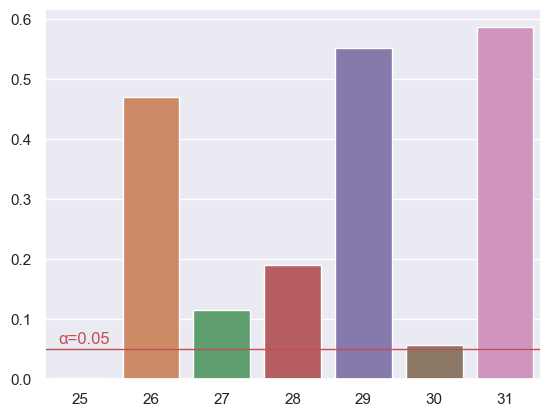

In [14]:
sns.barplot(x=list(p_values.keys()), y=list(p_values.values()))

plt.axhline(y=0.05 ,linewidth=1, color='r')
plt.text(-0.3,0.06,"α=0.05", color='r')
plt.show()

В целом результаты статистически значимо отличаются, но возникает вопрос почему такой сильный разброс происходит. Можно продолжить исследование данных, посмотрев кумулятивный p-value, проверить на выбросы и.т.д.

Но на данный момент я был бы готов сделать вывод, что, исходя из 25го числа и общей тенденции - наша фича (Понижение коэффициента surge) не была сразу понята и не вызвала пика, но постепенно значения становятся все более и более статистически значимыми

То есть мы можем отвергнуть нулевую гипотезу (изменение price-to-order конверсии после понижения коэффициента surge является статистически значимым) и принять альтернативную (то, что изменение, все таки, является статистически значимым)

Тем не менее данные я бы перепроверил конечно если на это есть время и возможность